# Progetto R

In [1]:
library(ggplot2)
library(RColorBrewer)
library(corrplot)
library(caret)
library(mlbench)
library(MLmetrics)
library(pROC)
library(scatterplot3d)
options(warn=-1)
set.seed(42)

corrplot 0.84 loaded

Loading required package: lattice


Attaching package: ‘MLmetrics’


The following objects are masked from ‘package:caret’:

    MAE, RMSE


The following object is masked from ‘package:base’:

    Recall


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




Before perfoming the following steps it is necessary to download data from [GECO](http://geco.deib.polimi.it/genosurf/) following the instructions displayed. It is necessarelecting the following for the query parameters:
* project_name: ['tcga-brca']
* assembly: ['grch38']
* data_type: ['gene expression quantification']
* is_healthy:
    * ['false'] for tumoral data 
    * [true] for normal data.
   


## Read input file
First of all we read the input file and we create a dataframe, we check if it contains null valuse. In our case thare are not null value so we are lucky because we do not have to handle them.
We can see that the dimensions of the dataframe are $ rows = 222$ and $columns = 60483$. Each row corresponds to a sample while each column correspond to a features that in our case is a gene. Our gool is to classify tumoral vs normal samples, so we can start plot the number of tumoral vs the number of normal sample in our dataframe.
We than normalize the data to center them in the origin.

In [2]:
data <- read.delim(file = 'data.txt', header = TRUE, sep = '\t')
print('There is any null value?')
any(is.na(data))
# get the target class 
target <- data$is_healthy 

[1] "There is any null value?"


[1] FALSE

In [3]:
dim(data)

[1]   222 60484

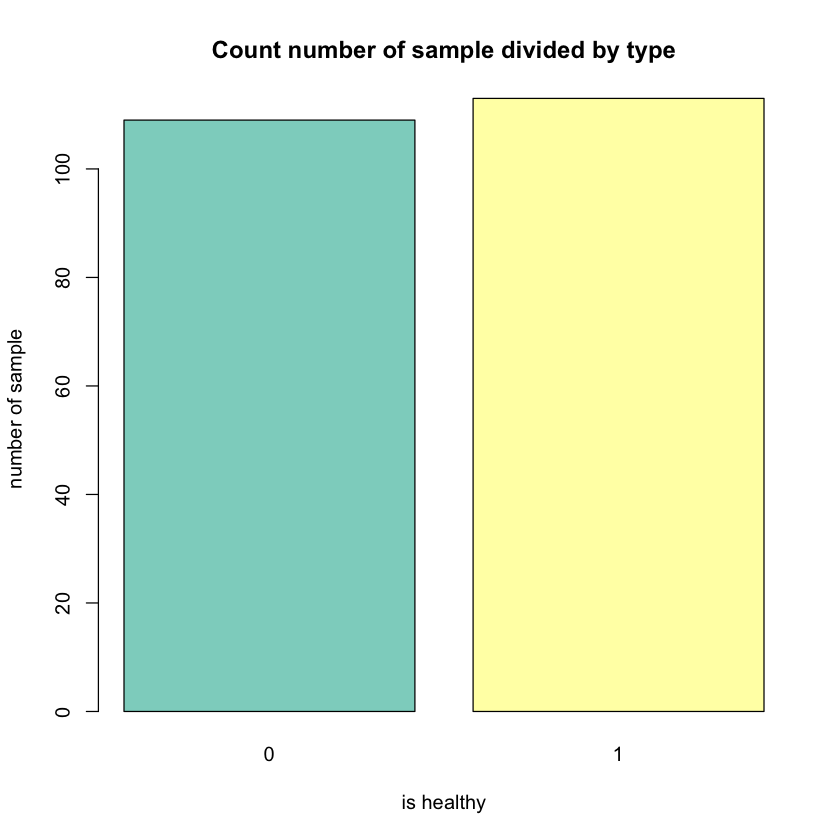

In [4]:
barplot(table(data$is_healthy),
        xlab="is healthy", 
        ylab="number of sample",
        main="Count number of sample divided by type",
        col=brewer.pal(3, "Set3")) # ho messo 3 perché lo richiede come numero minimo altrimenit mi esce il wharning

In [5]:
data$is_healthy <- NULL
data <- as.matrix(data)
data <- (data - mean(data)) / sd(data)
head(data)

,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.3,ENSG00000274890.1,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.5,⋯,ENSGR0000237040.4,ENSGR0000124333.13,ENSGR0000228410.4,ENSGR0000223484.5,ENSGR0000124334.15,ENSGR0000270726.4,ENSGR0000185203.10,ENSGR0000182484.13,ENSGR0000276543.3,ENSGR0000227159.6
1,-0.04284205,-0.03967896,-0.04127097,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04281338,⋯,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205
2,-0.04284205,-0.03902230,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04272664,⋯,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205
3,-0.04284205,-0.03595032,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04232146,⋯,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205
4,-0.04284205,-0.03843439,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,⋯,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205
5,-0.04284205,-0.03740185,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04277033,⋯,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205
6,-0.04284205,-0.03401461,-0.03797037,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04279760,⋯,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205,-0.04284205


## Feature Selection 
We have to select the features that are most important because the number of features is huge and so the performance as well as the results obtained in the classification will improve after the features selection. We will try to use the principal components in order to performe the features selection. We plot the proportion of variance expressed and the cumulative variance expressed by the first 20 principal components. As we can see we can select the first 5 principal components because they expresse more than 90% of the total variance. Now that we have the princiapl components we use the first 3 principal component to plot the data in a 3 dimensions features space. As we can see with only 3 principal components the data do not seems to be very well separated even if we can clearly see that they are clusterd in two groups. So using the first 5 principal component the data in the 5-dimensions features space will be certainly well separated.  

In [6]:
pcs <- prcomp(data)
#compute standard deviation
std_dev <-pcs$sdev
#compute the variance
pr_var <- std_dev^2
#proportion of variance expressed by each pcs
prop_varex <- pr_var/sum(pr_var)

function (distinct = FALSE) 
{
    c <- .Call(C_colors)
    if (distinct) 
        c[!duplicated(t(col2rgb(c)))]
    else c
}
<bytecode: 0x7fd8113ae158>
<environment: namespace:grDevices>

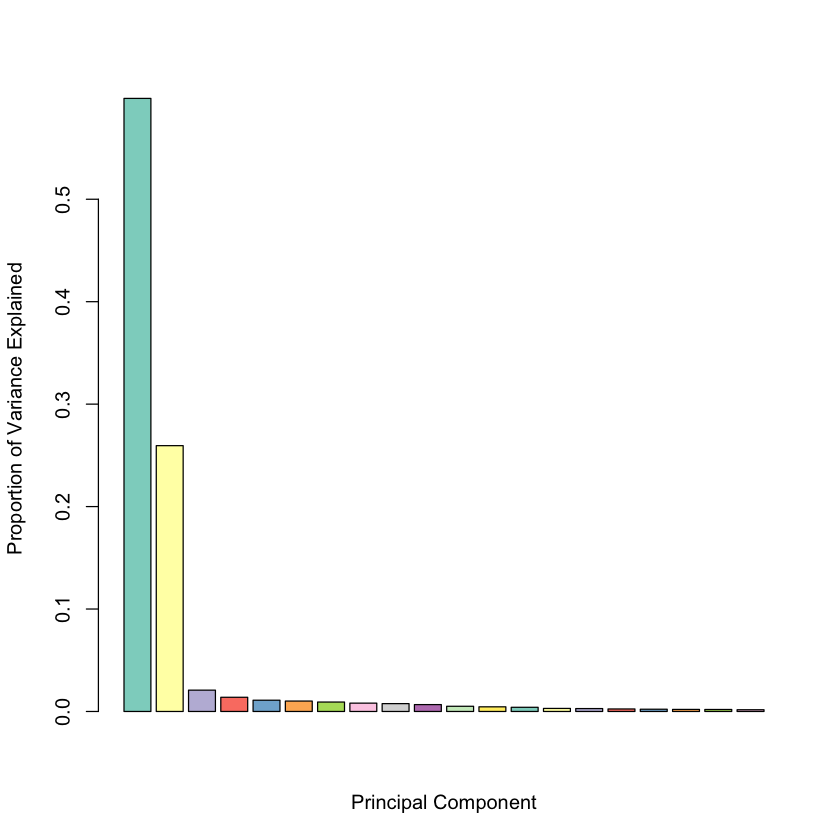

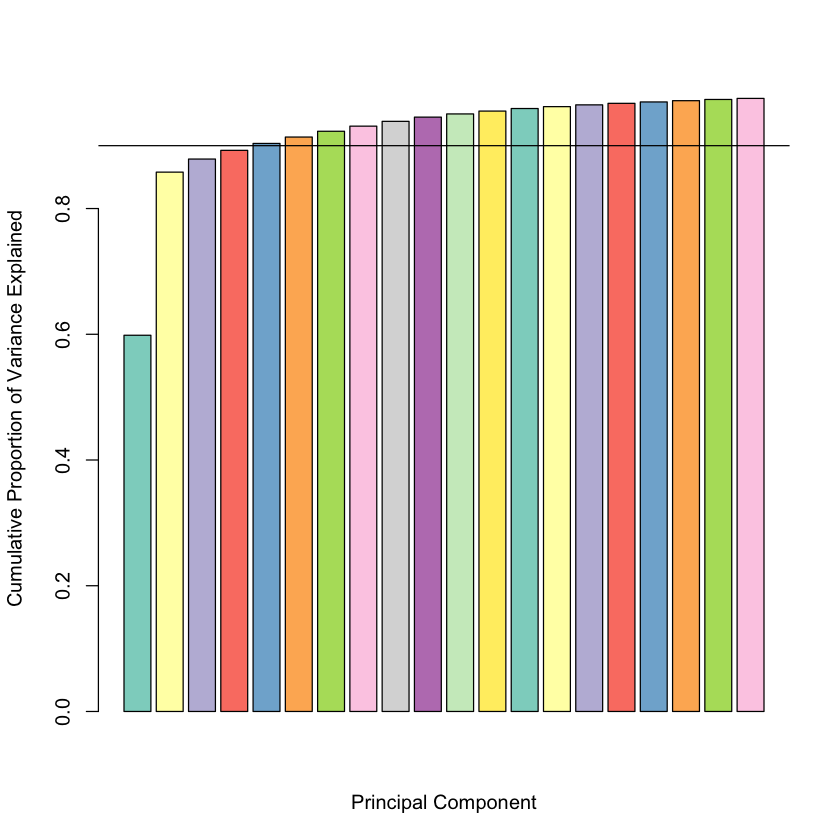

In [7]:
# plot the first 20 principal components
barplot(prop_varex[1:20], xlab = "Principal Component",
     ylab = "Proportion of Variance Explained",  col=brewer.pal(20, "Set3"))

#plot the cumulative variance expressed by the first 20 principal components
colors
barplot(cumsum(prop_varex[1:20]), xlab = "Principal Component",
       ylab = "Cumulative Proportion of Variance Explained",
       type = "b", col=brewer.pal(20, "Set3"))
abline(h = .90)


In [8]:
# create the new axes and value 
data.pca <- as.matrix(predict(pcs, newdata = data))
# normalize the data
data.pca <- (data.pca - mean(data.pca)) / sd(data.pca)
data.pca <- data.pca[, 1:5]
data.pca <- cbind(data.pca, target)

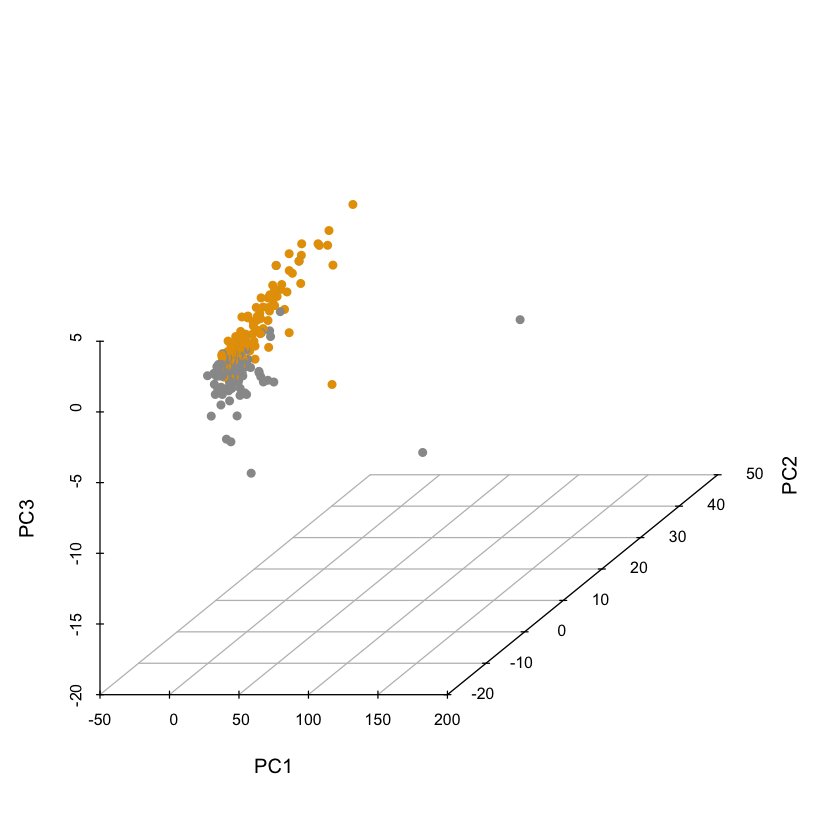

In [9]:
data.plot <- as.data.frame(data.pca)
colors <- c("#999999", "#E69F00")
colors <- colors[as.factor(data.plot$target)]
scatterplot3d(data.plot[1:3], pch = 16, box= FALSE, color=colors)

## Model selection
Now we are finally ready to perform the model selection. But first we have to split the dataset. We can follow two way:
* Split the dataset in train, validation and test
* Split the dataset in train and test and use k-fold cross validation

We will follow the second way, initially we will split the dataframe in train and test using the 75% of the data for the train and the remaning for the test. Than we will perform the training of our models using a 10-fold cross validation.
In particular we will train the following models:
* Linear Support Vector Machine
* Polynomial Support Vector Machine
* Radial Support Vector Machine 
* Logistic Regression
* K Nearest Neighbor 

All the classifiers achieve good performance (the results are plotted below), but in the end we select the Polynomial Support Vector Machine because it seems the one that  gives the most consistent results. 

In [10]:
# test and train split
smp_size <- floor(0.75 * nrow(data.pca))

train_ind <- sample(seq_len(nrow(data.pca)), size = smp_size)

train <- data.pca[train_ind, ]
test <- data.pca[-train_ind, ]

In [11]:
# k-fold cross val
train_control <- trainControl(method="repeatedcv", number=10, repeats=3)


svmLin <- train(as.factor(target) ~., data = train, method = "svmLinear", 
                trControl = train_control,  preProcess = c("center","scale"), 
                tuneGrid = expand.grid(C = seq(0, 2, length = 20)))

svmPol<- train(as.factor(target) ~., data = train, method = "svmPoly", 
                trControl = train_control,  preProcess = c("center","scale"))

svmRad <- train(as.factor(target) ~., data = train, method = "svmRadial", 
                trControl = train_control,  preProcess = c("center","scale"))


logreg <- train(as.factor(target) ~., data = train, method="glm", 
                family = binomial(), trControl = train_control,  
                preProcess = c("center","scale"))

knn <- train(as.factor(target) ~., data = train, method="knn", 
                trControl = train_control, preProcess = c("center","scale"),
                tuneLength = 10) #  10 differents K 

In [12]:
svmLin

Support Vector Machines with Linear Kernel 

166 samples
  5 predictor
  2 classes: '0', '1' 

Pre-processing: centered (5), scaled (5) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 148, 149, 150, 150, 149, 150, ... 
Resampling results across tuning parameters:

  C          Accuracy   Kappa    
  0.0000000        NaN        NaN
  0.1052632  0.8852533  0.7701049
  0.2105263  0.8867375  0.7731383
  0.3157895  0.8926198  0.7849182
  0.4210526  0.8867375  0.7729245
  0.5263158  0.8830474  0.7655149
  0.6315789  0.8791258  0.7577553
  0.7368421  0.8770425  0.7535887
  0.8421053  0.8771650  0.7538477
  0.9473684  0.8771650  0.7538477
  1.0526316  0.8791258  0.7577553
  1.1578947  0.8791258  0.7577553
  1.2631579  0.8791258  0.7577553
  1.3684211  0.8791258  0.7577553
  1.4736842  0.8791258  0.7577553
  1.5789474  0.8791258  0.7577553
  1.6842105  0.8752042  0.7498299
  1.7894737  0.8752042  0.7498299
  1.8947368  0.8752042  0.7498299
  2.0000000  0.87520

In [13]:
svmPol

Support Vector Machines with Polynomial Kernel 

166 samples
  5 predictor
  2 classes: '0', '1' 

Pre-processing: centered (5), scaled (5) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 149, 149, 150, 149, 150, 150, ... 
Resampling results across tuning parameters:

  degree  scale  C     Accuracy   Kappa     
  1       0.001  0.25  0.5174020  0.05833333
  1       0.001  0.50  0.5174020  0.05833333
  1       0.001  1.00  0.5193627  0.06184211
  1       0.010  0.25  0.6150735  0.24100930
  1       0.010  0.50  0.7364379  0.47208599
  1       0.010  1.00  0.8067130  0.61249247
  1       0.100  0.25  0.8569989  0.71345489
  1       0.100  0.50  0.8730528  0.74554970
  1       0.100  1.00  0.8753949  0.74967569
  2       0.001  0.25  0.5174020  0.05833333
  2       0.001  0.50  0.5193627  0.06184211
  2       0.001  1.00  0.5448529  0.10797202
  2       0.010  0.25  0.7383987  0.47600811
  2       0.010  0.50  0.8128404  0.62484432
  2       0.010  1.00

In [14]:
svmRad

Support Vector Machines with Radial Basis Function Kernel 

166 samples
  5 predictor
  2 classes: '0', '1' 

Pre-processing: centered (5), scaled (5) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 149, 150, 149, 149, 148, 150, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.8475899  0.6954673
  0.50  0.8629493  0.7267784
  1.00  0.8647876  0.7297990

Tuning parameter 'sigma' was held constant at a value of 0.6188278
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.6188278 and C = 1.

In [15]:
logreg

Generalized Linear Model 

166 samples
  5 predictor
  2 classes: '0', '1' 

Pre-processing: centered (5), scaled (5) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 149, 150, 148, 149, 149, 150, ... 
Resampling results:

  Accuracy   Kappa    
  0.8732162  0.7458081


In [16]:
knn

k-Nearest Neighbors 

166 samples
  5 predictor
  2 classes: '0', '1' 

Pre-processing: centered (5), scaled (5) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 148, 150, 150, 149, 149, 149, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.8772331  0.7538789
   7  0.8892429  0.7780623
   9  0.8849537  0.7695262
  11  0.8831155  0.7657682
  13  0.8873911  0.7743609
  15  0.8893519  0.7782116
  17  0.8835784  0.7665213
  19  0.8817266  0.7628176
  21  0.8779139  0.7552062
  23  0.8757217  0.7506743

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 15.

## Model evaluation 
We will use different metrics to evaluate our model on test set, in particular:
* accuracy:
 
\begin{equation} \label{eq:accuracy}
  accuracy = \frac{number \; of \; incorrect \; prediction}{Total \; number \; of \; prediction} 
\end{equation}


* precision (specificity):
\begin{equation} \label{eq:precision}
  accuracy = \frac{true \; positive}{true \; positive \; + \; false \; positive} 
\end{equation}
* recall (sensitivity):
\begin{equation} \label{eq:recall}
  accuracy = \frac{true \; positive}{true \; positive \; + \; false \; negative} 
\end{equation}

* roc: which plot the $1 - Specificity$ vs $Sensitivity$
* confusion matrix: a table in which the principal diagonal contain the number of sample correctly classified and the element off diagonal are the sample misclassified


In particular we can notice that we have a very high precision, so if our classifier says that a sample belongs to a certain class we are pretty sure that is correct, but a sample is correctly classified "only" with a probability of 0.84.

For the roc curve we can see that the AUC is 0.85 that is a quite good value considering that the best value is 1. 

In the end we can notice, using the correlation matrix, that our classifier tends to classify a tumoral sample when in reality is a normal sample. This is results is not so bad after all, because if a sample that is normal is classified as tumoral we can always performe other test to be sure.


In [17]:
target.test <- test[, ncol(test)]
test <- test[, -ncol(test)]
predicted <- as.numeric(as.character(predict(svmPol, test)))

In [18]:
accuracy <- round(Accuracy(predicted, target.test), 2)
precision <- round(Precision(predicted, target.test, positive = 1), 2)
recall <- round(Recall(predicted, target.test, positive = 1), 2)
metrics <- data.frame(accuracy, precision, recall)
print(metrics)

  accuracy precision recall
1     0.86       0.9   0.84


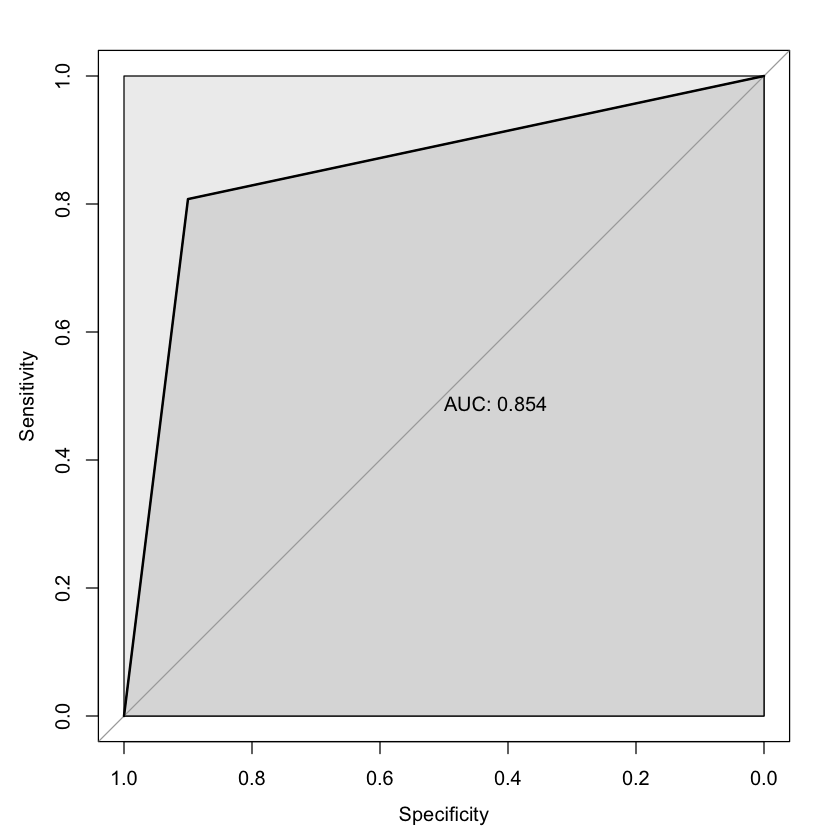

In [19]:
# in my case controll = 1 cases = 0 this because target = is_healthy
pROC <- roc(target.test, predicted,
                plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE,
                print.auc=TRUE, levels = c(1, 0), direction = '>')

In [41]:
matrix <- confusionMatrix(as.factor(target.test), as.factor(predicted), 
                dnn = c("Predicted Class", "True Class"), positive = '1')

matrix$table

               True Class
Predicted Class  0  1
              0 21  5
              1  3 27

# THE END